In [1]:
print('Link Energy optimization')

Link Energy optimization


In [2]:
import os
import sys
import comtypes.client
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pygad

In [4]:
SapObject = comtypes.client.GetActiveObject("CSI.SAP2000.API.SapObject")
SapModel = SapObject.SapModel
SapModel.SetModelIsLocked(False)

0

In [5]:
def link_option(Y_strength, L_name):
    """
    Modifies the yield strength of the selected link element
    Arguments:
        Y_strength: new yield strength
        L_name: Link name
    Returns:
        returns 0 if it works
    """
    DOF = [False, False, False, False, False, False]
    Fixed = [False, False, False, False, False, False]
    NonLinear = [False, False, False, False, False, False]
    Ke = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Ce = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    K =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Yield = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Ratio = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Exp =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    DOF[0] = True
    Fixed[0] = True

    DOF[1] = True
    Fixed[1] = True

    DOF[2] = True
    Fixed[2] = True

    DOF[3] = True
    Fixed[3] = True

    DOF[3] = True
    Fixed[3] = True

    DOF[4] = True
    Fixed[4] = True

    DOF[5] = True
    NonLinear[5] = True
    Ke[5] = 100000
    Ce[5] = 0
    K[5] = 100000
    Yield[5] = Y_strength
    Ratio[5] = 0.03
    Exp[5] = 2
    ret = SapModel.PropLink.SetPlasticWen(L_name, DOF, Fixed, NonLinear, Ke, Ce, K, Yield, Ratio, Exp, 2, 0)

In [6]:
def energy_func(result):
    result['dist'] = result['Force']**2+result['Desplacment']**2
    X = []
    try : 
        test = result[result['Force'] >= 0.0]
        test2 = test[test['Desplacment'] >= 0.0]
        max_X = test2[test2['dist'] == test2['dist'].max()]
        X.append([max_X.iloc[0]['Desplacment'], max_X.iloc[0]['Force']])
    except :
        X.append([0,0])
    try:
        test = result[result['Force'] < 0.0]
        test2 = test[test['Desplacment'] > 0.0]
        max_X = test2[test2['dist'] == test2['dist'].max()]
        X.append([max_X.iloc[0]['Desplacment'], max_X.iloc[0]['Force']])
    except :
        X.append([0,0])
    try :
        test = result[result['Force'] < 0.0]
        test2 = test[test['Desplacment'] < 0.0]
        max_X = test2[test2['dist'] == test2['dist'].max()]
        X.append([max_X.iloc[0]['Desplacment'], max_X.iloc[0]['Force']])
    except :
        X.append([0,0])
    try :
        test = result[result['Force'] > 0.0]
        test2 = test[test['Desplacment'] < 0.0]
        max_X = test2[test2['dist'] == test2['dist'].max()]
        X.append([max_X.iloc[0]['Desplacment'], max_X.iloc[0]['Force']])
    except :
        X.append([0,0])
    
    
    E= (X[1][0]-X[2][0])*(X[3][1]-X[2][1])-(X[1][1]-X[2][1])*(X[3][0]-X[2][0])
    return E

1.4671800069825354


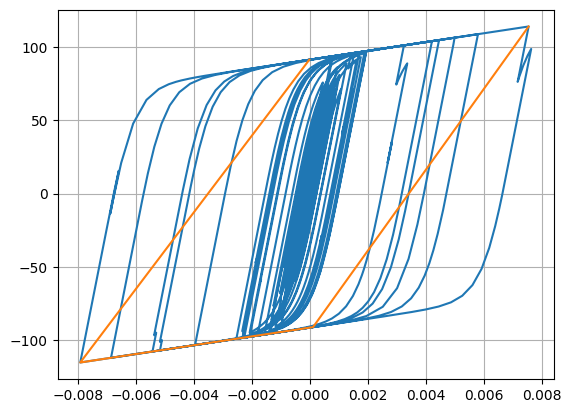

In [200]:
test = pd.read_csv(r'C:\Users\Amatek\Documents\GitHub\Optimisation_dissipative_KBF\plots\[94.25516697, 93.13785414, 91.77189876, 133.8643788, 44.82925985]\1.csv')

test2 , X_pts = energy_func(test) 
X_pts = np.array(X_pts)

plt.plot(test['Desplacment'], test['Force'])
plt.plot(X_pts[:,0], X_pts[:,1])
plt.grid()

In [7]:
def get_data(L_num, save_path,Plot_graph = True):
    """
    Gets the analysis results
    Arguments:
        L_num: Link number
        save_path: Path to save hysteresis plots of the selected link
        Plot_graph : Display the hysteresis plots of the selected link
    Returns:
        result : Pandas DataFrame with the analysis results
        Energy : Hysteresis plots of the selected link
    """
    eItemTypeElm = 1
    NumberResults = 0
    Obj =[]
    Elm =[]
    PointElm =[]
    LoadCase =[]
    StepType =[]
    StepNum =[]
    P =[]
    V2 =[]
    V3 =[]
    T =[]
    M2 =[]
    M3 =[]

    U1=[]
    U2=[]
    U3=[]
    R1=[]
    R2=[]
    R3=[]
    [NumberResults, Obj, Elm, LoadCase,PointElm, StepType, StepNum, P, V2, V3, T, M2, M3, ret] = SapModel.Results.LinkForce(L_num, eItemTypeElm, NumberResults, Obj, Elm, PointElm, LoadCase, StepType, StepNum, P, V2, V3, T, M2, M3)
    [NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3, ret]= SapModel.Results.LinkDeformation(L_num, eItemTypeElm, NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
    result = pd.DataFrame()

    result['Desplacment'] = R3
    result['Force'] = M3[0:len(M3):2]

    if Plot_graph:
        plt.plot(result['Desplacment'], result['Force'])
        plt.grid()
        save_path_csv = save_path + '/'+ str(L_num) + ".csv"
        save_path = save_path + '/'+ str(L_num) + ".png"
        result.to_csv(save_path_csv, index = False)
        plt.savefig(save_path)
        plt.close()

    Energy = energy_func(result)

    #Energy = np.abs(result['Desplacment'][len(result)-1]*result['Force'][0] - result['Desplacment'][0]*result['Force'][len(result)-1])/2
    #Energy = 0
    #for i in range(len(result)-1):
    #    #Area = result['Desplacment'][i]*result['Force'][i+1] - result['Desplacment'][i+1]*result['Force'][i]
    #    Area = (result['Force'][i] + result['Force'][i+1]) / 2 * (result['Desplacment'][i+1]- result['Desplacment'][i])
    #    Energy = Energy +  np.abs(Area)
    return result, Energy

In [23]:
def drift_check(story_ids):
    for joint in story_ids :
        eItemTypeElm = 1
        NumberResults = 0
        Obj =[]
        Elm =[]
        PointElm =[]
        LoadCase =[]
        StepType =[]
        StepNum =[]


        U1=[]
        U2=[]
        U3=[]
        R1=[]
        R2=[]
        R3=[]
        SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()
        SapModel.Results.Setup.SetCaseSelectedForOutput("ARTIF1")
        SapModel.Results.Setup.SetOptionModalHist(3)
        [NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3, ret]= SapModel.Results.JointDisplAbs(joint, eItemTypeElm, NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3)

        print(U1)
    #return Check

joints = ["2", "13", "27", "38", "49"]
drift_check(joints)

(0.6294215468854997,)
(0.6290371563197162,)
(0.6306126022457269,)
(0.6303884574198575,)
(0.6300161894160227,)


In [203]:
def cycle_number(result):
    result['q2'] = 0
    result['c'] = 0
    q1 = 0
    q2 = 0
    c = 0
    for i in range(len(result)-1):
        if result['Force'][i] >= 0.0 and result['Desplacment'][i] >= 0.0 : 
            q2 = 1
            result['q2'][i] = q2
        if result['Force'][i] < 0.0 and result['Desplacment'][i] > 0.0 : 
            q2 = 2
            result['q2'][i] = q2
        if result['Force'][i] < 0.0 and result['Desplacment'][i] < 0.0 : 
            q2 = 3
            result['q2'][i] = q2
        if result['Force'][i] > 0.0 and result['Desplacment'][i] < 0.0 : 
            q2 = 4
            result['q2'][i] = q2
        
        
        if q1 > q2 and q2 ==1:
            c += 1
        result['c'][i] = c

        q1 = q2
    return c


In [213]:
def main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit):
    """
    Calculates the total hysteresis energy of the structure for a selected yield strength values
    Aeguments : 
        Y_strength : List of Yield strengths for each link
        Link_names : Link section names
        Link_labels : Links labels
        Load_case_name : Non-linear load case name
    Returns :
        Total hysteresis energy of the structure
    """
    print(Y_strength)
    SapModel.SetModelIsLocked(False)
    Link_list = Link_names
    Link_numbers = Link_labels
    for link_name in Link_list:
        link_option( Y_strength[Link_list.index(link_name)], link_name)
    
    SapModel.Analyze.RunAnalysis()
    SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()
    SapModel.Results.Setup.SetCaseSelectedForOutput(Load_case_name)
    SapModel.Results.Setup.SetOptionModalHist(2)


    E = []
    plot_dirc = os.path.join("plots/", str(Y_strength)) 
    os.makedirs(plot_dirc, exist_ok=True) 
    for num in Link_numbers:
        r, e = get_data(num, plot_dirc)
        if cycle_number(r) > Cycle_limit: 
            E_tot = 0
            break
        E.append(e)
    E_tot = 10 * np.sum(E)
    print("E=", E_tot)
    


    return E_tot
#23, 95

In [9]:
Y_strength = [ 94.25516697,  93.13785414,  91.77189876, 133.8643788,   44.82925985]
#Y_strength = [380.79067813, 274.57431279, 238.83024146, 174.14506668, 494.81132781]

Cycle_limit = 45

Link_names = ['LINK1', 'LINK2','LINK3','LINK4','LINK5']

num_links = 20
Link_labels = range(1, num_links+1)
Link_labels = [format(x, 'd') for x in Link_labels]


Load_case_name = "ARTIF1"
print("Initial Energy value : ",10*main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit))

NameError: name 'main' is not defined

In [219]:
def fitness_func(solution, solution_idx):
    return main(solution, Link_names, Link_labels, Load_case_name, Cycle_limit)

last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

fitness_function = fitness_func

num_generations = 5 #iteratinos
num_parents_mating = 3

sol_per_pop = 5 # solutions per iteration
num_genes = len(Y_strength)

init_range_low = 90
init_range_high = 600

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 50

ga_instance = pygad.GA(#on_generation=on_generation,
                        num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes
                       )

In [220]:
ga_instance.run()

[229.78033381 295.09674587 450.89677491 314.34199323 278.62326174]
E= 234.479822220234
[471.12773728 392.5591694  587.73107195 278.35898697 489.11550355]
E= 122.39911818463068
[510.36805531 420.48919828 100.3829448   95.70690047 148.51956471]
E= 107.08352563612779
[563.54965091 292.71390833 511.64720226 177.59008355 429.33309682]
E= 129.08467377494517
[ 96.39948626 587.11154182  98.7045659  587.13500202 356.14072345]
E= 96.62249745302915
[229.78033381 295.34660613 450.89677491 177.6079908  429.33309682]
E= 233.5053925770065
[563.54965091 292.71390833 587.59079727 279.16579951 489.11550355]
E= 131.25763554990607
[471.17764979 295.09674587 450.32162731 314.34199323 278.62326174]
E= 206.2662026312425
[564.16622834 293.47666391 511.64720226 177.59008355 429.33309682]
E= 129.06448692623576
[229.78033381 295.09674587 450.89677491 177.55844893 429.37657552]
E= 233.50869045050632
[229.78033381 295.34660613 451.69882911 314.10315161 278.62326174]
E= 233.6591861447653
[229.78033381 294.98789109 